# Day 3: TextCNN模型训练

实现和训练TextCNN模型进行中文新闻分类


In [ ]:
# Cell 1: 导入库
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# 导入自定义模块
from src.models.textcnn import TextCNN
from src.utils.dataset import TextDataset

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 检查GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
print("导入成功")


使用设备: cuda
导入成功


In [ ]:
# Cell 2: 加载数据
print("加载数据...")

train_dataset = TextDataset('../data/processed/train_processed.pkl')
val_dataset = TextDataset('../data/processed/val_processed.pkl')
test_dataset = TextDataset('../data/processed/test_processed.pkl')

# 创建DataLoader
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\n训练集: {len(train_dataset)} 条, {len(train_loader)} batches")
print(f"验证集: {len(val_dataset)} 条, {len(val_loader)} batches")
print(f"测试集: {len(test_dataset)} 条, {len(test_loader)} batches")

# 读取词表
with open('../data/processed/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
    
print(f"词表大小: {len(vocab)}")
print("数据加载完成")


加载数据...
加载数据: 45462 条
加载数据: 9742 条
加载数据: 9743 条

训练集: 45462 条, 711 batches
验证集: 9742 条, 153 batches
测试集: 9743 条, 153 batches
词表大小: 117355
数据加载完成


In [ ]:
# Cell 3: 初始化模型
print("初始化TextCNN模型...")

model = TextCNN(
    vocab_size=len(vocab),
    embed_dim=300,
    num_classes=14,
    num_filters=100,
    filter_sizes=[3, 4, 5],
    dropout=0.5
)

model = model.to(device)

# 打印模型结构
print(model)
print(f"\n模型参数量: {sum(p.numel() for p in model.parameters()):,}")
print("模型初始化完成")


初始化TextCNN模型...
TextCNN(
  (embedding): Embedding(117355, 300)
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=300, out_features=14, bias=True)
)

模型参数量: 35,571,014
模型初始化完成


In [ ]:
# Cell 4: 定义训练和评估函数

def train_epoch(model, dataloader, criterion, optimizer, device):
    """训练一个epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for ids, labels in tqdm(dataloader, desc='Training'):
        ids = ids.to(device)
        labels = labels.to(device)
        
        # 前向传播
        outputs = model(ids)
        loss = criterion(outputs, labels)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 统计
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy


def evaluate(model, dataloader, criterion, device):
    """评估模型"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for ids, labels in tqdm(dataloader, desc='Evaluating'):
            ids = ids.to(device)
            labels = labels.to(device)
            
            outputs = model(ids)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy

print("训练函数定义完成")


训练函数定义完成


In [ ]:
# ===== 重新训练（使用类别权重）=====
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

print("="*60)
print("使用加权损失函数重新训练")
print("="*60)


print("\n重新初始化模型...")
model = TextCNN(
    vocab_size=len(vocab),
    embed_dim=300,
    num_classes=14,
    num_filters=100,
    filter_sizes=[3, 4, 5],
    dropout=0.5
).to(device)

# 3. 使用加权损失函数
criterion = nn.CrossEntropyLoss()

# 4. 优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 5. 学习率调度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2
)

# 6. 训练参数
num_epochs = 10
best_val_acc = 0
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("配置完成，开始训练...")


使用加权损失函数重新训练

重新初始化模型...
配置完成，开始训练...


In [ ]:
# Cell 6: 开始训练！
print("="*60)
print("开始训练TextCNN模型")
print("="*60)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 40)
    
    # 训练
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # 验证
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    # 记录
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # 打印结果
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # 保存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '../output/textcnn_best.pth')
        print(f"保存最佳模型 (Val Acc: {val_acc:.2f}%)")
    
    # 学习率调度
    scheduler.step(val_acc)

print("\n" + "="*60)
print(" 训练完成！")
print("="*60)
print(f"最佳验证准确率: {best_val_acc:.2f}%")


开始训练TextCNN模型

Epoch 1/10
----------------------------------------


Evaluating: 100%|██████████| 153/153 [00:01<00:00, 121.41it/s]


Train Loss: 0.8651, Train Acc: 74.23%
Val Loss: 0.3058, Val Acc: 91.17%
保存最佳模型 (Val Acc: 91.17%)

Epoch 2/10
----------------------------------------


Evaluating: 100%|██████████| 153/153 [00:01<00:00, 122.59it/s]


Train Loss: 0.4314, Train Acc: 87.29%
Val Loss: 0.2264, Val Acc: 93.27%
保存最佳模型 (Val Acc: 93.27%)

Epoch 3/10
----------------------------------------


Evaluating: 100%|██████████| 153/153 [00:01<00:00, 121.77it/s]


Train Loss: 0.3280, Train Acc: 90.42%
Val Loss: 0.1967, Val Acc: 94.42%
保存最佳模型 (Val Acc: 94.42%)

Epoch 4/10
----------------------------------------


Evaluating: 100%|██████████| 153/153 [00:01<00:00, 120.00it/s]


Train Loss: 0.2439, Train Acc: 92.69%
Val Loss: 0.1904, Val Acc: 94.56%
保存最佳模型 (Val Acc: 94.56%)

Epoch 5/10
----------------------------------------


Evaluating: 100%|██████████| 153/153 [00:01<00:00, 118.53it/s]


Train Loss: 0.1718, Train Acc: 94.74%
Val Loss: 0.1839, Val Acc: 94.72%
保存最佳模型 (Val Acc: 94.72%)

Epoch 6/10
----------------------------------------


Evaluating: 100%|██████████| 153/153 [00:01<00:00, 117.84it/s]


Train Loss: 0.1184, Train Acc: 96.29%
Val Loss: 0.1988, Val Acc: 94.72%

Epoch 7/10
----------------------------------------


Evaluating: 100%|██████████| 153/153 [00:01<00:00, 114.24it/s]


Train Loss: 0.0867, Train Acc: 97.36%
Val Loss: 0.1960, Val Acc: 94.88%
保存最佳模型 (Val Acc: 94.88%)

Epoch 8/10
----------------------------------------


Evaluating: 100%|██████████| 153/153 [00:01<00:00, 114.06it/s]


Train Loss: 0.0669, Train Acc: 97.91%
Val Loss: 0.2065, Val Acc: 94.94%
保存最佳模型 (Val Acc: 94.94%)

Epoch 9/10
----------------------------------------


Evaluating: 100%|██████████| 153/153 [00:01<00:00, 111.62it/s]


Train Loss: 0.0546, Train Acc: 98.24%
Val Loss: 0.2305, Val Acc: 94.53%

Epoch 10/10
----------------------------------------


Evaluating: 100%|██████████| 153/153 [00:01<00:00, 110.97it/s]

Train Loss: 0.0438, Train Acc: 98.62%
Val Loss: 0.2314, Val Acc: 94.83%

 训练完成！
最佳验证准确率: 94.94%


NameError: name 'history' is not defined

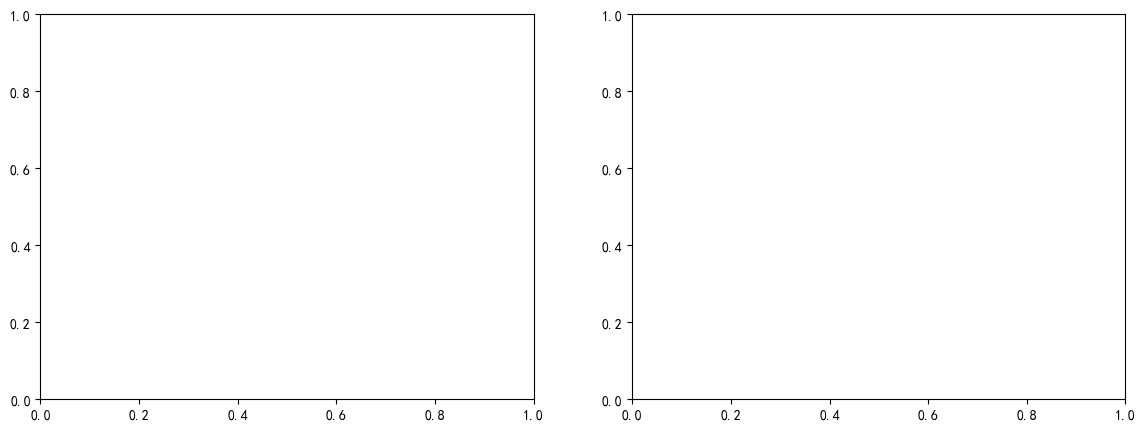

In [ ]:
# Cell 7: 可视化训练过程
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文显示
plt.rcParams['axes.unicode_minus'] = False

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 损失曲线
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('训练和验证损失')
ax1.legend()
ax1.grid(True)

# 准确率曲线
ax2.plot(history['train_acc'], label='Train Acc', marker='o')
ax2.plot(history['val_acc'], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('训练和验证准确率')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('../output/textcnn_training_curve.png', dpi=150)
plt.show()

print("训练曲线已保存")


In [ ]:
# Cell 8: 在测试集上评估
print("在测试集上评估最佳模型...")

# 加载最佳模型
model.load_state_dict(torch.load('../output/textcnn_best.pth'))

test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print("\n" + "="*60)
print("TextCNN模型最终结果")
print("="*60)
print(f"测试集准确率: {test_acc:.2f}%")
print(f"测试集损失: {test_loss:.4f}")
print("="*60)

print("\nTextCNN模型训练和评估完成！")



在测试集上评估最佳模型...


NameError: name 'model' is not defined

In [4]:
# 检查实际的文本长度
train = pd.read_pickle('../data/processed/train_processed.pkl')

# 计算非padding的长度
def get_real_length(ids):
    return len([x for x in ids if x != 0])

train['real_len'] = train['ids'].apply(get_real_length)

print("文本长度统计（分词后）:")
print(f"平均长度: {train['real_len'].mean():.1f} 词")
print(f"中位数: {train['real_len'].median():.1f} 词")
print(f"最大: {train['real_len'].max()} 词")
print(f"最小: {train['real_len'].min()} 词")

# 长度分布
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']

# 计算平均值（避免f-string引号冲突）
mean_len = train['real_len'].mean()

plt.figure(figsize=(10, 5))
plt.hist(train['real_len'], bins=50)
plt.xlabel('文本长度（词数）')
plt.ylabel('频数')
plt.title('文本长度分布')
plt.axvline(mean_len, color='r', linestyle='--', label=f'平均{mean_len:.1f}')
plt.legend()
plt.show()

# 统计
count_10 = (train['real_len'] < 10).sum()
count_20 = (train['real_len'] < 20).sum()
print(f"\n<10词的文本: {count_10} ({count_10/len(train)*100:.1f}%)")
print(f"<20词的文本: {count_20} ({count_20/len(train)*100:.1f}%)")

NameError: name 'pd' is not defined